In [1]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, BatchNormalization, Conv1D

Using TensorFlow backend.


In [2]:
def add_ic_layer(X, name, dropout=0.2):
    X = BatchNormalization(name=f"{name}_bn")(X)
    if dropout:
        X = Dropout(dropout, name=f"{name}_dropout")(X)
    return X

def add_lstm_layer(X, name, params):
    ic_params = params.pop("ic_params") if "ic_params" in params else {}
    X = LSTM(name=name, **params)(X)
    return add_ic_layer(X, name, **ic_params)
    
def get_lstm_model(
    shape_input,
    lstm_layers,
    conv1d_params=None,
    dense_units=30,
    dense_dropout=0.2,
):
    
    X_input = Input(shape_input, name="input")
    X = X_input
    
    if conv1d_params is not None:
        name = "conv1d"
        X = Conv1D(
            name=name,
            **conv1d_params,
        )(X)
        X = Activation("relu", name=f"{name}_relu")(X)
        X = add_ic_layer(X, name)
    
    num_lstm_layers = len(lstm_layers)
    for i in range(num_lstm_layers):
        name = f"lstm_{i + 1}"
        params = lstm_layers[i]
        if i < num_lstm_layers - 1:
            params["return_sequences"] = True
        X = add_lstm_layer(X, name, params)
    
    name = "dense"
    X = Dense(dense_units, activation="relu", name=name)(X)
    X = add_ic_layer(X, name, dense_dropout)
    
    X = Dense(1, activation='sigmoid', name="output")(X)
    
    return Model(inputs=X_input, outputs=X)

In [3]:
NUM_SAMPLES = 10
NUM_FEATURES = 13
SAMPLE_SIZE = 128

model_one = get_lstm_model(
    (NUM_SAMPLES, NUM_FEATURES * SAMPLE_SIZE),
    [
        { "units": 128, "dropout": 0.2, "ic_params": { "dropout": 0.2 } },
        { "units": 128, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params=None,
)
model_two = get_lstm_model(
    (NUM_SAMPLES * SAMPLE_SIZE, NUM_FEATURES),
    [
        { "units": 128, "dropout": 0, "ic_params": { "dropout": 0.2 } },
        { "units": 128, "ic_params": { "dropout": 0.2 } },
    ],
    conv1d_params={"filters": 196, "kernel_size": 15, "strides": 4},
)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 1664)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           918016    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 10, 128)           512       
_________________________________________________________________
lstm_1_dropout (Dropout)     (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
lstm_2_bn (BatchNormalizatio (None, 128)               512       
_________________________________________________________________
lstm_2_dropout (Dropout)     (None, 128)               0   

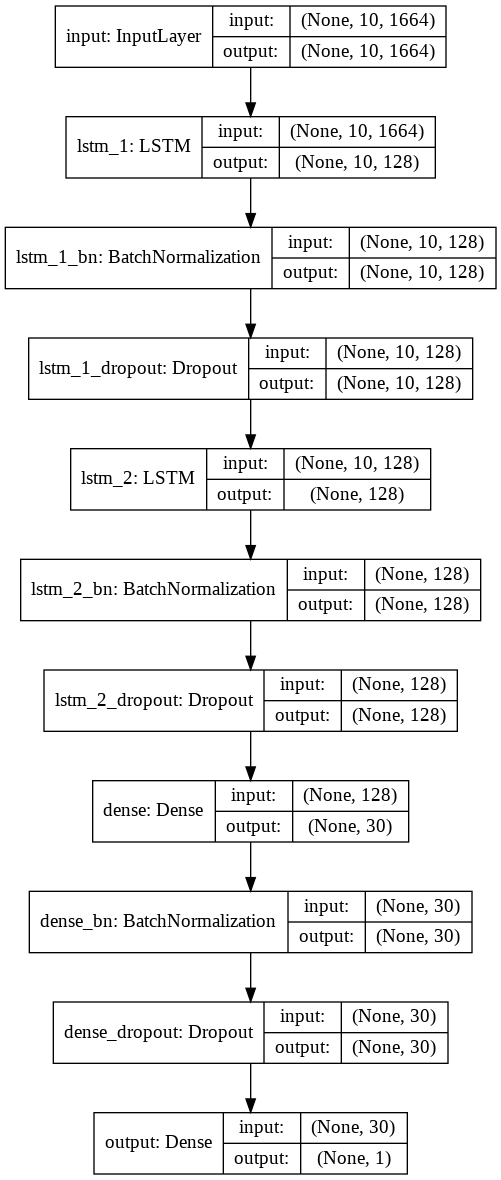

In [4]:
from keras.utils import plot_model
model_one.summary()
plot_model(model_one, to_file='model_one.png', show_shapes=True, show_layer_names=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1280, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 317, 196)          38416     
_________________________________________________________________
conv1d_relu (Activation)     (None, 317, 196)          0         
_________________________________________________________________
conv1d_bn (BatchNormalizatio (None, 317, 196)          784       
_________________________________________________________________
conv1d_dropout (Dropout)     (None, 317, 196)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 317, 128)          166400    
_________________________________________________________________
lstm_1_bn (BatchNormalizatio (None, 317, 128)          512 

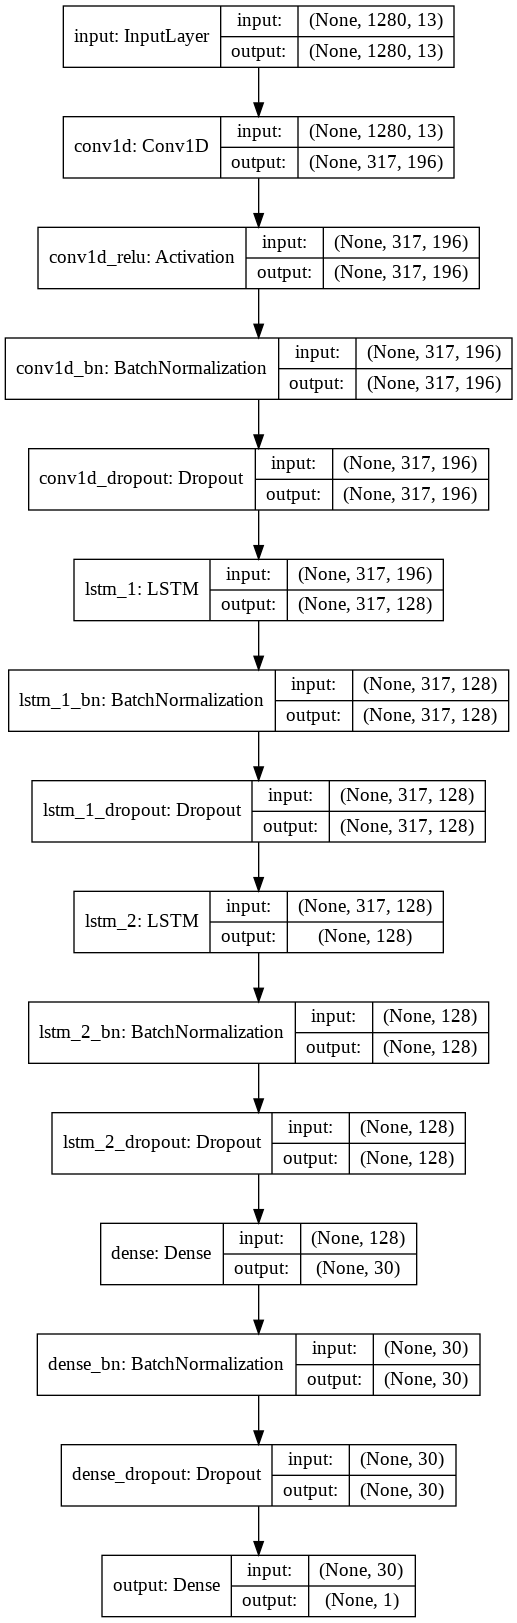

In [5]:
model_two.summary()
plot_model(model_two, to_file='model_two.png', show_shapes=True, show_layer_names=True)

In [6]:
from keras.optimizers import Adam

def compile_model(
    model,
    learning_rate=0.01,
    beta_one=0.9,
    beta_two=0.999,
    decay=0.01,
):
    opt = Adam(learning_rate, beta_one, beta_two, decay)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
LEARNING_RATE=0.1
BETA_ONE=0.9
BETA_TWO=0.999
DECAY=0.01
compile_model(model_one, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)
compile_model(model_two, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)